In [414]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [415]:
## Load previous results of tanimoto similarities and simba results
## based on the tanimoto similarities, retrieve the spectra that corresponds to the best candidate for each query
## find if the best candidate is in the 10 first matches

In [416]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [417]:
import dill
from src.preprocessor import Preprocessor
from src.load_data import LoadData
from src.config import Config
from rdkit import Chem
import numpy as np

## Parameters

In [418]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'edit_distance_neurips_nist_exhaustive.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
casmi_file= data_folder + 'processed_massformer/spec_df.pkl' 
USE_CASMI=True
USE_MCES_RAW=False

In [419]:
similarities_files= [
#'simba_EDIT_DISTANCE_MCES20_NEURIPS_20241115',
#'simba_EDIT_DISTANCE_MCES20_NEURIPS_precursor_randomized',
    'modified_cosine_casmi_NEURIPS',
    'ms2deepscore_v2_casmi_NEURIPS',
    #'simba_generated_data_20250126',
    'simba_generated_data_20250130',
'spec2vec_casmi_NEURIPS',
                    ]

#model_results_path='simba_EDIT_DISTANCE_MCES20_NEURIPS'
#model_results_path='spec2vec_casmi_NEURIPS'
#model_results_path='ms2deepscore_casmi_NEURIPS'

In [420]:
tanimoto_results_path = 'tanimoto_similarity_casmi_NEURIPS'

In [421]:
format_file_unknown = "./notebooks/discovery_search/results/{}_results_analog_discovery_unknwon_compounds.pkl"

In [422]:
config=Config()

## Load reference dataset

In [423]:
pp=Preprocessor()


In [424]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [425]:
all_spectrums_reference_original= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original

In [426]:
import copy
all_spectrums_reference_processed= [copy.deepcopy(s) for s in all_spectrums_reference_original]

In [427]:
all_spectrums_reference_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_reference_processed]
    
all_spectrums_reference = [s_original for s_original, s_processed in zip(all_spectrums_reference_original,all_spectrums_reference_processed) if len(s_processed.mz)>=6]

## Load query spectra

In [428]:
if USE_CASMI:
    all_spectrums_janssen_original=LoadData.get_all_spectrums_casmi(
        casmi_file,
        config=config,
    )
else:
    loader_saver = LoaderSaver(
            block_size=100,
            pickle_nist_path='',
            pickle_gnps_path='',
            pickle_janssen_path=output_janssen_file,
        )
    all_spectrums_janssen_original = loader_saver.get_all_spectrums(
                janssen_path,
                100000000,
                use_tqdm=True,
                use_nist=False,
                config=config,
                use_janssen=True,
            )

In [429]:
all_spectrums_janssen_processed= [copy.deepcopy(s) for s in all_spectrums_janssen_original]

In [430]:
pp=Preprocessor()
### remove extra peaks in janssen
all_spectrums_janssen_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_janssen_processed]

all_spectrums_janssen = [s_original for s_original, s_processed in zip(all_spectrums_janssen_original,all_spectrums_janssen_processed) if len(s_processed.mz)>=6]

## Get only the spectra that is not present

In [431]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [432]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(26, 132)

In [433]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## Load similarity results

## Load results for simba and spec2vec

In [434]:
model_results = {}
for sim in similarities_files:
    with open(format_file_unknown.format(sim), 'rb') as f:
                model_results[sim]= dill.load(f)

In [435]:
with open(format_file_unknown.format(tanimoto_results_path), 'rb') as f:
                tanimoto_results= dill.load(f)

## Get similarities of mod cosine

In [436]:
similarities_modcos=model_results['modified_cosine_casmi_NEURIPS']['similarities']

## Get similarities of simba

In [437]:
similarities_simba=model_results['simba_generated_data_20250130']['similarities']

## Binarize modcos

In [438]:
similarities_modcos_bin =similarities_modcos.copy()
condition= (similarities_modcos_bin>0.5)
similarities_modcos_bin[condition]=1
similarities_modcos_bin[~condition]=0

(array([2.91868e+05, 2.25000e+04, 7.76900e+03, 3.54600e+03, 2.00400e+03,
        5.38000e+02, 1.70000e+02, 1.13000e+02, 3.00000e+01, 1.70000e+01]),
 array([0.        , 0.07719464, 0.15438928, 0.23158392, 0.30877856,
        0.3859732 , 0.46316784, 0.54036248, 0.61755712, 0.69475176,
        0.7719464 ]),
 <BarContainer object of 10 artists>)

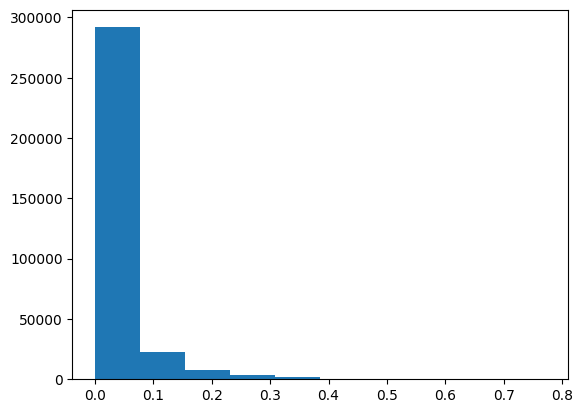

In [439]:
plt.hist(similarities_modcos[0])

In [440]:
similarities_simba

array([[0.45200347, 0.47218274, 0.52551628, ..., 0.02141498, 0.03519959,
        0.13493936],
       [0.7819117 , 0.76245682, 0.86796122, ..., 0.04501834, 0.07057875,
        0.27617598],
       [0.4859856 , 0.49757575, 0.5672901 , ..., 0.02798314, 0.03985634,
        0.04034941],
       ...,
       [0.81886442, 0.85829161, 0.87645295, ..., 0.26237008, 0.25389661,
        0.46974479],
       [0.96469389, 0.9063901 , 0.93267185, ..., 0.55090015, 0.47238666,
        0.42459558],
       [0.85799638, 0.81676127, 0.7837531 , ..., 0.21549512, 0.18669629,
        0.14232625]])

In [441]:
import numpy as np

def compute_ranking(similarities1, similarities1_integer, similarities2_integer, max_value_2_int=1):
    # Preallocate the ranking array with the same shape as similarities1.
    ranking_total = np.zeros(similarities1.shape, dtype=int)
    
    # Process each row (or each set of values) individually.
    for row_index, (row_sim, row_int, row_int2) in enumerate(zip(similarities1, similarities1_integer, similarities2_integer)):
        # Use lexsort with a composite key:
        #   - Primary: similarities1_integer (ascending)
        #   - Secondary: similarities2_integer (ascending)
        #   - Tertiary: similarities1 (descending, so use -row_sim)
        #
        # Note: np.lexsort uses the last key as the primary key.
        sorted_indices = np.lexsort( ( row_sim, row_int2, row_int ) )
        
        # Now assign ranking values based on sorted order.
        # Here the best (first in sorted_indices) gets rank 0,
        # the next gets rank 1, etc.
        ranking = np.empty_like(sorted_indices)
        ranking[sorted_indices] = np.arange(len(row_sim))
        
        # Store the ranking for this row.
        ranking_total[row_index] = ranking

    #normalizing
    ranking_total =ranking_total/ranking_total.shape[1]
    return ranking_total

In [442]:
similarities1_integer=np.around(similarities_simba*40).astype(int)

In [443]:
ranking_total = compute_ranking(similarities_simba, similarities1_integer, similarities_modcos_bin)


In [444]:
ranking_total

array([[0.45200347, 0.4721797 , 0.52551628, ..., 0.02141498, 0.03519959,
        0.13493936],
       [0.78188127, 0.76242029, 0.86793688, ..., 0.04501529, 0.0705757 ,
        0.27613337],
       [0.48597039, 0.49757575, 0.56728402, ..., 0.02798314, 0.03985634,
        0.04034941],
       ...,
       [0.81846266, 0.8573146 , 0.87546073, ..., 0.26140524, 0.25325745,
        0.46935216],
       [0.96465128, 0.90605226, 0.93204486, ..., 0.5506171 , 0.472201  ,
        0.42438861],
       [0.85783507, 0.81675519, 0.78371658, ..., 0.21549208, 0.18662629,
        0.14230798]])

In [445]:
results ={ 'smiles_janssen' : model_results['simba_generated_data_20250130']['smiles_janssen'], 
        'smiles_reference' : model_results['simba_generated_data_20250130']['smiles_reference'], 
        'mces_retrieved':None,
          'similarities':ranking_total,
         }
with open('./notebooks/discovery_search/results/'+ 'simba_modcos' + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)

In [446]:
np.max(ranking_total[0,:])

0.9999969563695577

In [447]:
np.argmax(ranking_total[0,:])

84365

In [448]:
np.argmin(ranking_total[0,:])

920

In [449]:
similarities_simba[0,920]

0.0

In [450]:
np.argmax(similarities_simba[0,:])

84365

In [451]:
similarities_simba[0,269444]

0.9991660452587847

In [452]:
similarities_simba[0,84365]

0.9999969563695577

In [453]:
similarities_modcos_bin[0,269444]

0.0

In [454]:
similarities_modcos_bin[0,84365]

1.0

In [455]:
similarities1_integer[0,84365]

40

In [456]:
similarities1_integer[0,269444]

40

In [457]:
dsds

NameError: name 'dsds' is not defined